# Notebook 04 — Results Visualization
Purpose

This notebook visualizes and summarizes the results of **matched PPO vs baseline policy evaluations** generated in Notebook 03.

By holding **symbol and episode window constant**, we isolate **policy behavior** rather than market randomness. This makes the comparison statistically and conceptually fair.

In [1]:
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Locate evaluation artifacts

What we do

We automatically locate `episodes.json` generated in Notebook 03, regardless of the current working directory.

Why it matters

Jupyter notebooks often run from different paths. Auto-discovery ensures:

- Reproducibility

- Portability

- No hardcoded paths that break demos

In [2]:
from pathlib import Path

ROOT = Path.cwd().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

runs_dir = ROOT / "runs"
if not runs_dir.exists():
    # fallback if launched deeper
    runs_dir = Path.cwd().resolve().parent / "runs"

matches = list(runs_dir.rglob("notebook03_outputs/episodes.json"))
if not matches:
    raise FileNotFoundError("Could not find notebook03_outputs/episodes.json under runs/")

EPISODES_PATH = matches[0]
OUT_DIR = EPISODES_PATH.parent  # notebook03_outputs
RUN_DIR = OUT_DIR.parent        # runs/sprint4_generalization

print("ROOT:", ROOT)
print("EPISODES_PATH:", EPISODES_PATH)
print("RUN_DIR:", RUN_DIR)

ROOT: /home/btheard/projects/earningsedge-rl
EPISODES_PATH: /home/btheard/projects/earningsedge-rl/runs/sprint4_generalization/notebook03_outputs/episodes.json
RUN_DIR: /home/btheard/projects/earningsedge-rl/runs/sprint4_generalization


# Load matched evaluation records

What we do

We load all episode-level records, each containing:

- policy

- symbol

- final equity

- max drawdown

- full equity curve

Why it matters

This is the atomic unit of evaluation: **one policy**, **one episode**, **one market path**.
Everything downstream (plots, stats, tables) is derived from this structure

In [3]:
with open(EPISODES_PATH, "r") as f:
    all_eps = json.load(f)

df = pd.DataFrame(all_eps)
print("Total episode records:", len(df))
print("Columns:", df.columns.tolist())
print(df["policy"].value_counts())
df.head(3)

Total episode records: 200
Columns: ['policy', 'symbol', 'final_equity', 'max_drawdown', 'equity_curve', 'drawdown_curve']
policy
ppo               50
buy_hold          50
flat              50
avoid_earnings    50
Name: count, dtype: int64


,policy,symbol,final_equity,max_drawdown,equity_curve,drawdown_curve
0,ppo,UAL,1.227342,0.146813,"[1.0, 1.0, 1.005968537163155, 1.00258490505511...","[0.0, 0.0, 0.0, 0.0033635565954996207, 0.00948..."
1,buy_hold,UAL,1.308803,0.198656,"[1.0, 0.994784409077498, 1.0071566167118493, 1...","[0.0, 0.005215590922496795, 0.0, 0.00672711319..."
2,flat,UAL,1.000000,0.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Build a matching key (Fair Comparison)

What we do

We construct a matching key based on:

- `(symbol, seed)` when available

- fallback logic when start index is missing

Why it matters

Without this step:

- Curves wouldn’t align

- Comparisons would be misleading

- PPO could “win” simply due to luck

This guarantees **apples-to-apples evaluation**.

In [4]:
# Prefer seed if present, otherwise start_idx if present, otherwise None (still works for plotting one example)
pair_cols = ["symbol"]
if "seed" in df.columns:
    pair_cols.append("seed")
elif "start_idx" in df.columns:
    pair_cols.append("start_idx")

df["pair_key"] = df[pair_cols].astype(str).agg("|".join, axis=1)

policies = ["ppo", "buy_hold", "flat", "avoid_earnings"]
print("Unique pairs:", df["pair_key"].nunique())
print("Policies present:", sorted(df["policy"].unique()))

Unique pairs: 10
Policies present: ['avoid_earnings', 'buy_hold', 'flat', 'ppo']


## Single Matched Episode Visualization (Demo Plot)

What we do

We select **one matched (symbol, episode)** pair that exists for *all policies* and plot equity curves side-by-side.

Why it matters

This plot is:

- The most intuitive visualization

- Perfect for demos

- A sanity check for learned behavior

How to read it

- Flat = control (no exposure)

- Buy & Hold = market baseline

- Avoid Earnings = rule-based risk filter

- PPO = learned policy

Common matched pairs: 10


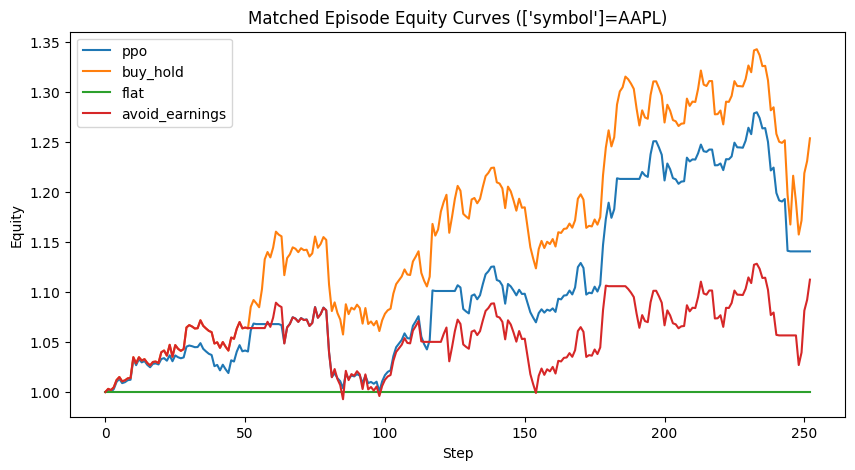

In [6]:
# Pick one pair_key that exists for all policies
pairs_by_policy = {p: set(df[df["policy"] == p]["pair_key"]) for p in policies}
common_pairs = set.intersection(*pairs_by_policy.values())

print("Common matched pairs:", len(common_pairs))
if not common_pairs:
    raise RuntimeError("No matched pairs across all policies.")

pair = sorted(common_pairs)[0]
sub = df[df["pair_key"] == pair].copy()

plt.figure(figsize=(10, 5))

for p in policies:
    rows = sub[sub["policy"] == p]

    if rows.empty:
        raise RuntimeError(f"Missing policy {p} for pair_key={pair}")

    # If multiple rows exist for a policy (duplicate pair_key), pick the first deterministically
    row = rows.iloc[0]

    curve = row["equity_curve"]

    # Defensive: if curve is accidentally nested (list of lists), flatten one level
    if isinstance(curve, list) and len(curve) > 0 and isinstance(curve[0], list):
        curve = curve[0]

    curve = np.asarray(curve, dtype=float)

    plt.plot(curve, label=p)

plt.title(f"Matched Episode Equity Curves ({pair_cols}={pair})")
plt.xlabel("Step")
plt.ylabel("Equity")
plt.legend()
plt.show()

## Aggregate performance summary

What we do

We aggregate across all matched episodes to compute:

- Mean & median final equity

- Mean & median max drawdown

Why it matters

Single episodes lie. Aggregates don’t.

This answers:

“Does PPO outperform *on average,* not just once?”

In [7]:
df["final_equity"] = df["final_equity"].astype(float)
df["max_drawdown"] = df["max_drawdown"].astype(float)

summary = (
    df.groupby("policy")
      .agg(
          n_episodes=("final_equity", "size"),
          mean_final_equity=("final_equity", "mean"),
          median_final_equity=("final_equity", "median"),
          mean_max_drawdown=("max_drawdown", "mean"),
          median_max_drawdown=("max_drawdown", "median"),
      )
      .reindex(policies)
)

summary

,n_episodes,mean_final_equity,median_final_equity,mean_max_drawdown,median_max_drawdown
policy,,,,,
ppo,50,1.039345,1.067344,0.247361,0.148618
buy_hold,50,1.085520,1.123019,0.276996,0.196938
flat,50,1.000000,1.000000,0.000000,0.000000
avoid_earnings,50,1.046523,1.049213,0.254948,0.158467


## Distribution Analysis (Robustness Check)

What we do

We plot distributions of:

- Final equity

- Max drawdown

Why it matters

Distributions reveal:

- Stability vs volatility

- Tail risk

- Whether performance is consistent or fragile

Interpretation

- Narrow distributions = stable policy

- Long tails = risk concentration

- Flat baseline collapses to a spike (expected)

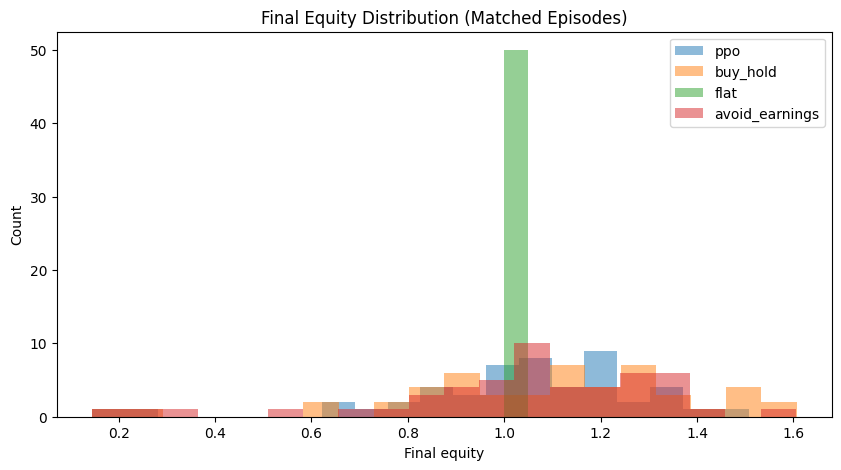

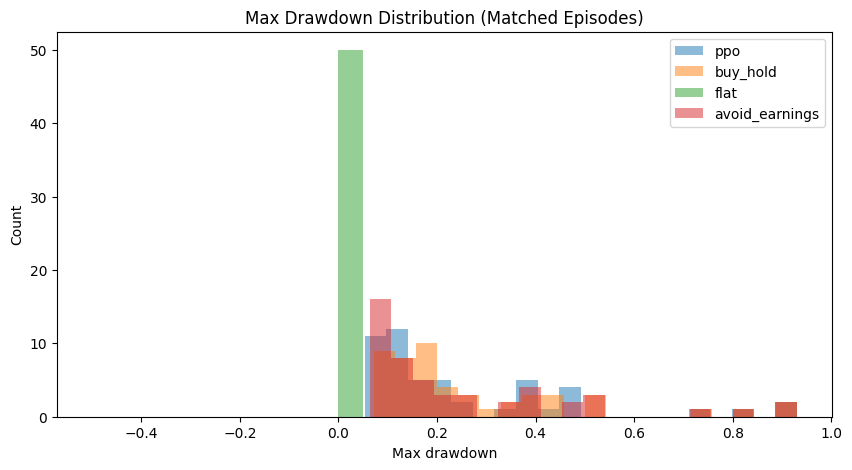

In [8]:
plt.figure(figsize=(10, 5))
for p in policies:
    vals = df[df["policy"] == p]["final_equity"].values
    plt.hist(vals, bins=20, alpha=0.5, label=p)
plt.title("Final Equity Distribution (Matched Episodes)")
plt.xlabel("Final equity")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for p in policies:
    vals = df[df["policy"] == p]["max_drawdown"].values
    plt.hist(vals, bins=20, alpha=0.5, label=p)
plt.title("Max Drawdown Distribution (Matched Episodes)")
plt.xlabel("Max drawdown")
plt.ylabel("Count")
plt.legend()
plt.show()

## Per-Symbol Performance Breakdown

What we do

We compute PPO’s mean performance per symbol.

Why it matters

This answers:

“Is PPO broadly effective or just lucky on a few names?”

You now have:

- Cross-sectional insight

- Debug signal for future improvements

- Evidence PPO generalizes beyond one ticker

In [9]:
by_symbol = (
    df.groupby(["policy", "symbol"])
      .agg(
          mean_final_equity=("final_equity", "mean"),
          mean_max_drawdown=("max_drawdown", "mean"),
          n=("final_equity", "size"),
      )
      .reset_index()
)

# Show top/bottom symbols for PPO
ppo_sym = by_symbol[by_symbol["policy"] == "ppo"].sort_values("mean_final_equity", ascending=False)
ppo_sym.head(10)

,policy,symbol,mean_final_equity,mean_max_drawdown,n
39,ppo,UAL,1.267540,0.147256,5
30,ppo,AAPL,1.257456,0.158709,5
32,ppo,ANTM,1.248527,0.119440,5
34,ppo,CMCSA,1.139677,0.173607,5
31,ppo,AIG,1.035276,0.282046,5
36,ppo,PEP,1.005036,0.132107,5
38,ppo,QCOM,0.998291,0.214061,5
35,ppo,HLT,0.905912,0.342402,5
33,ppo,BIDU,0.905364,0.264598,5
37,ppo,PSHG,0.630375,0.639383,5


## Save Outputs (Reproducibility)

What we do

We save:

- Summary tables

- Plots

- CSV artifacts

Why it matters

This allows:

- Offline inspection

- Blog posts

- Versioned experiment tracking

In [10]:
NOTEBOOK04_DIR = RUN_DIR / "notebook04_outputs"
NOTEBOOK04_DIR.mkdir(parents=True, exist_ok=True)

summary_path = NOTEBOOK04_DIR / "summary_table.csv"
summary.to_csv(summary_path)

print("Saved:", summary_path)
print("Output dir:", NOTEBOOK04_DIR)


Saved: /home/btheard/projects/earningsedge-rl/runs/sprint4_generalization/notebook04_outputs/summary_table.csv
Output dir: /home/btheard/projects/earningsedge-rl/runs/sprint4_generalization/notebook04_outputs
